In [ ]:
#Summary

# Inputs: Inflow, Precipitation, Evaporation. Daily data 10 years.
# Outputs: inflow uptil 30 days, 60 days, 90 days ahead

#HOW TO RUN
#0. Get the correct path in Mount Drive
#1. Change Configuration
#2. Run all blocks except (Ignore) blocks

In [ ]:
#To-Do: 
    #Add the correct evaluation metric. We only need MSE for last output. Build custom function. - Done
    #Add uncertainty estimates using Monte-Carlo Dropout - Done
    #In make_dataset, we put shuffle=True. Be careful! On test-set, put shuffle=False - Done
    #Try NSE Loss function - not required. NeuralHydrology paper tells it doesn't make much difference. - Done
    #for krs, include outflow from harangi nd hemavati. for others, don't - Done
    #Get the correct date format - Done

In [5]:
#@title #####Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_path = '/content/gdrive/My Drive/Colab Notebooks/'
%cd '/content/gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [6]:
# @title ####imports
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Configuration

In [1431]:
#Data
DAM='krs' #@param ['harangi','kabini','krs','hemavathi']
#START_DATE='2013-06-11'
#END_DATE='2020-12-16'
LABEL_WIDTH =  30#@param #days to predict
INPUT_WIDTH =  365#@param #past input days
SHIFT = 1 #@param # predict timesteps ahead
LABEL_WIDTH_DISPLAY = 20 #@param #how many predictions to plot at once. The model still trains only on LABEL_WIDTH, this is for plotting
#for instance: train a model on 60 days data, predict output till 30 days ahead, show 20 such outputs at once in plot.

#Model
MAX_EPOCHS = 30 #@param
PATIENCE = 15 #@param # stops training if overfitting. dont set it too low.

l1_reg=0.001 #@param
l2_reg=0.001 #@param
DROPOUT=0.3 #@param
RECURRENT_DROPOUT=0.3 #@param

#LSTM_HIDDEN_LAYERS = 3 #standard is 3 for short input width, 1 for long
#HIDDEN_SIZE=32


# Data Cleaning and Transformation

In [1432]:
inputs=pd.read_csv(f'{DAM}_combined_db.csv')
inputs

,Date,inflow,precipitation,evaporation,sim_inflow,outflow_harangi,outflow_hemavathi
0,1/1/2011,294.2,5272.0,60910.0,57.46128,0.0,56.66832
1,1/2/2011,230.9,0.0,113100.0,87.33888,0.0,55.22400
2,1/3/2011,225.6,0.0,138900.0,78.61632,0.0,55.22400
3,1/4/2011,195.3,0.0,137800.0,65.44752,0.0,30.44400
4,1/5/2011,200.7,0.0,130300.0,52.30704,0.0,15.57600
...,...,...,...,...,...,...,...
3648,12/27/2020,153.6,0.0,130300.0,NaN,NaN,NaN
3649,12/28/2020,150.5,0.0,117200.0,NaN,NaN,NaN
3650,12/29/2020,146.9,0.0,117600.0,NaN,NaN,NaN
3651,12/30/2020,143.7,0.0,125000.0,NaN,NaN,NaN


In [1433]:
inputs.info(), inputs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               3653 non-null   object 
 1   inflow             3653 non-null   float64
 2   precipitation      3653 non-null   float64
 3   evaporation        3653 non-null   float64
 4   sim_inflow         3307 non-null   float64
 5   outflow_harangi    3465 non-null   float64
 6   outflow_hemavathi  3306 non-null   float64
dtypes: float64(6), object(1)
memory usage: 199.9+ KB


(None,
             inflow  precipitation  ...  outflow_harangi  outflow_hemavathi
 count  3653.000000   3.653000e+03  ...      3465.000000        3306.000000
 mean    311.566739   1.787583e+05  ...        34.596119          70.980472
 std     375.074974   3.742916e+05  ...        83.076456         116.814561
 min       1.590000   0.000000e+00  ...         0.000000           0.000000
 25%      75.280000   0.000000e+00  ...         0.000000           5.664000
 50%     211.300000   1.195000e+04  ...         1.982400          28.320000
 75%     425.300000   1.973000e+05  ...        43.896000         123.192000
 max    5836.000000   5.139000e+06  ...      2225.640480        2769.696000
 
 [8 rows x 6 columns])

In [1434]:
#inputs=inputs.drop(['sim_inflow'], axis=1) ##Seems to overfit with this information at times.

inputs=inputs.dropna()
inputs.info(), inputs.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3298 entries, 0 to 3637
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               3298 non-null   object 
 1   inflow             3298 non-null   float64
 2   precipitation      3298 non-null   float64
 3   evaporation        3298 non-null   float64
 4   sim_inflow         3298 non-null   float64
 5   outflow_harangi    3298 non-null   float64
 6   outflow_hemavathi  3298 non-null   float64
dtypes: float64(6), object(1)
memory usage: 206.1+ KB


(None,
             inflow  precipitation  ...  outflow_harangi  outflow_hemavathi
 count  3298.000000   3.298000e+03  ...      3298.000000        3298.000000
 mean    326.090593   1.857968e+05  ...        36.234450          71.145780
 std     367.782929   3.751874e+05  ...        84.799107         116.907894
 min       1.598000   0.000000e+00  ...         0.000000           0.000000
 25%      90.225000   0.000000e+00  ...         0.000000           5.664000
 50%     228.900000   2.080000e+04  ...         2.265600          28.320000
 75%     443.150000   2.143250e+05  ...        44.483640         123.192000
 max    5836.000000   5.139000e+06  ...      2225.640480        2769.696000
 
 [8 rows x 6 columns])

In [1435]:
#about 10% data missing
#sim_inflow, outflow_harangi has non-numeric values, hence not showing in describe()
# there seem to be not any outliers or fill values such as '-999' etc.

In [1436]:
#inputs['level']=pd.to_numeric(inputs['level'], errors='coerce')
#inputs['inflow']=pd.to_numeric(inputs['inflow'], errors='coerce')
# inputs['sim_inflow']=pd.to_numeric(inputs['sim_inflow'], errors='coerce')
# inputs['outflow_harangi']=pd.to_numeric(inputs['outflow_harangi'], errors='coerce')
# 
inputs['date']=pd.to_datetime(inputs['Date'])
#inputs.dropna()
# inputs.info(), inputs.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


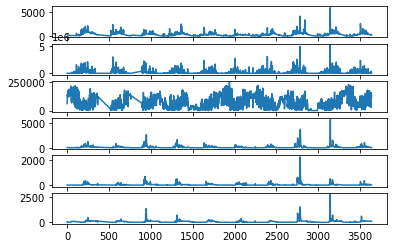

In [1437]:
#all seems ok. still plotting to see
if DAM=='krs':
    fig,axs=plt.subplots(6)
    axs[0].plot(inputs['inflow'])
    axs[1].plot(inputs['precipitation'])
    axs[2].plot(inputs['evaporation'])
    axs[3].plot(inputs['sim_inflow'])
    axs[4].plot(inputs['outflow_harangi'])
    axs[5].plot(inputs['outflow_hemavathi'])
else:
    fig,axs=plt.subplots(4)
    axs[0].plot(inputs['inflow'])
    axs[1].plot(inputs['precipitation'])
    axs[2].plot(inputs['evaporation'])
    axs[3].plot(inputs['sim_inflow'])

In [1438]:
#How to handle missing values in time-series data with strong seasonality?
# 1. simply remove the data
# 2. data imputation (method depends on keeping in mind the seasonality)

# For quick testing: https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners
# for understanding: https://www.nature.com/articles/s41598-018-24271-9

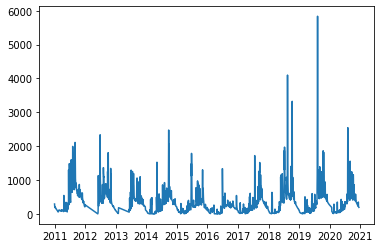

In [1439]:
plt.plot(inputs['date'], inputs['inflow'])
# most missing values are in a continuous range. So simply omitting for now
#my (untested) assumption is that if we simply omit these values, there are only 2-3 places where our network will perform bad. These will be ignored in a model that does not overfit

In [1440]:
# fig, axs=plt.subplots()
# axs.plot(inputs['date'], inputs['storage'], color='red')
# axs2=axs.twinx() #data had different range. so plotted on separate y-axes
# axs2.plot(inputs['date'], inputs['outflow'], color='blue')
# plt.show()

In [1441]:
# #Method 1: removing missing values
# inputs=inputs.dropna()
# inputs.info()

In [1442]:
# plt.plot(inputs['date'], inputs['storage'])

In [1443]:
# #ETS (Error- Trend - Seasonality)
# from statsmodels.tsa.seasonal import seasonal_decompose
# # ETS Decomposition of storage and date
# subset=inputs[['storage', 'date']]
# subset=subset.set_index('date')
# subset=subset.asfreq('D')

# result = seasonal_decompose(subset['storage'], 
#                             model ='additive')
  
# # ETS plot 
# result.plot()

In [1444]:
#converting date to a better, smoother feature (since data has cyclic tendencies yearly, it is better to show that Dec-2015 is as similar to Jan-2016  as  March is to april)
#To-do: Fast Fourier Transform to find correct frequencies
#https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning

#For now, not doing anything, just finding numeric values of date, month, year

In [1445]:
# day=30.0
# month=12.0
# year=365
# inputs['Day sin'] = np.sin(inputs['day'] * (2 * np.pi / day))
# inputs['Day cos'] = np.cos(inputs['day'] * (2 * np.pi / day))
# inputs['Month sin'] = np.sin(inputs['month'] * (2 * np.pi / month))
# inputs['Month cos'] = np.cos(inputs['month'] * (2 * np.pi / month))
# inputs['Year sin'] = np.sin(inputs['year'] * (2 * np.pi / year))
# inputs['Year cos'] = np.cos(inputs['year'] * (2 * np.pi / year))
# inputs
# plt.plot(np.array(inputs['Month sin'])[:100])
inputs['day']=pd.DatetimeIndex(inputs['date']).day
inputs['month']=pd.DatetimeIndex(inputs['date']).month
inputs['year']=pd.DatetimeIndex(inputs['date']).year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [1446]:
inputs

,Date,inflow,precipitation,evaporation,sim_inflow,outflow_harangi,outflow_hemavathi,date,day,month,year
0,1/1/2011,294.2,5272.0,60910.0,57.46128,0.0000,56.66832,2011-01-01,1,1,2011
1,1/2/2011,230.9,0.0,113100.0,87.33888,0.0000,55.22400,2011-01-02,2,1,2011
2,1/3/2011,225.6,0.0,138900.0,78.61632,0.0000,55.22400,2011-01-03,3,1,2011
3,1/4/2011,195.3,0.0,137800.0,65.44752,0.0000,30.44400,2011-01-04,4,1,2011
4,1/5/2011,200.7,0.0,130300.0,52.30704,0.0000,15.57600,2011-01-05,5,1,2011
...,...,...,...,...,...,...,...,...,...,...,...
3633,12/12/2020,214.3,0.0,146900.0,99.00672,21.8064,124.60800,2020-12-12,12,12,2020
3634,12/13/2020,208.1,0.0,140800.0,90.53904,21.8064,124.60800,2020-12-13,13,12,2020
3635,12/14/2020,202.5,0.0,150300.0,85.69632,21.5232,123.75840,2020-12-14,14,12,2020
3636,12/15/2020,199.0,0.0,119200.0,71.64960,18.6912,121.77600,2020-12-15,15,12,2020


In [1447]:
#DOUBLE CHECK
# using only data from 2013-06-11 to 2020-12-16' which is mostly continous
#inputs=inputs[(inputs.date>=START_DATE) & (inputs.date<=END_DATE)]
LAST_DATE=inputs['date'].tail(1).iloc[0]
LAST_DATE

Timestamp('2020-12-16 00:00:00')

In [1448]:
inputs=inputs.drop(['date'],axis=1)
inputs=inputs.drop(['Date'], axis=1)
inputs

,inflow,precipitation,evaporation,sim_inflow,outflow_harangi,outflow_hemavathi,day,month,year
0,294.2,5272.0,60910.0,57.46128,0.0000,56.66832,1,1,2011
1,230.9,0.0,113100.0,87.33888,0.0000,55.22400,2,1,2011
2,225.6,0.0,138900.0,78.61632,0.0000,55.22400,3,1,2011
3,195.3,0.0,137800.0,65.44752,0.0000,30.44400,4,1,2011
4,200.7,0.0,130300.0,52.30704,0.0000,15.57600,5,1,2011
...,...,...,...,...,...,...,...,...,...
3633,214.3,0.0,146900.0,99.00672,21.8064,124.60800,12,12,2020
3634,208.1,0.0,140800.0,90.53904,21.8064,124.60800,13,12,2020
3635,202.5,0.0,150300.0,85.69632,21.5232,123.75840,14,12,2020
3636,199.0,0.0,119200.0,71.64960,18.6912,121.77600,15,12,2020


In [1449]:
inputs.info(), inputs.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3298 entries, 0 to 3637
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inflow             3298 non-null   float64
 1   precipitation      3298 non-null   float64
 2   evaporation        3298 non-null   float64
 3   sim_inflow         3298 non-null   float64
 4   outflow_harangi    3298 non-null   float64
 5   outflow_hemavathi  3298 non-null   float64
 6   day                3298 non-null   int64  
 7   month              3298 non-null   int64  
 8   year               3298 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 257.7 KB


(None,             inflow  precipitation  ...        month         year
 count  3298.000000   3.298000e+03  ...  3298.000000  3298.000000
 mean    326.090593   1.857968e+05  ...     6.788053  2015.741965
 std     367.782929   3.751874e+05  ...     3.427699     2.820019
 min       1.598000   0.000000e+00  ...     1.000000  2011.000000
 25%      90.225000   0.000000e+00  ...     4.000000  2014.000000
 50%     228.900000   2.080000e+04  ...     7.000000  2016.000000
 75%     443.150000   2.143250e+05  ...    10.000000  2018.000000
 max    5836.000000   5.139000e+06  ...    12.000000  2020.000000
 
 [8 rows x 9 columns])

In [1450]:
# # Importing required libraries
# from statsmodels.tsa.seasonal import seasonal_decompose
# # ETS Decomposition
# result = seasonal_decompose(db_1['storage'], model ='multiplicative')
  
# # ETS plot 
# result.plot()

# Setting up for models

In [1451]:
#CROSS VALIDATION


In [1452]:
#setup based on https://www.tensorflow.org/tutorials/structured_data/time_series
df=inputs

#split data 70%-20%-10% (train-validation-test). Since this is time-series data, please don't shuffle.
# if 365 days input, then split 65-20-15.
#To-do: Cross-validation
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
#test_df=df[int(n*0.9):]
test_df=df[int(n*0.9)-INPUT_WIDTH:]#Not a data corruption. Only inputs are from valset, not the outputs. 
#We do it for a fair compare among different models, who otherwise may or may not see seasonal spikes

num_features = df.shape[1]

In [1453]:
len(test_df),len(val_df)

(695, 660)

In [1454]:
test_df

,inflow,precipitation,evaporation,sim_inflow,outflow_harangi,outflow_hemavathi,day,month,year
2921,119.80,0.0,0.0,12.82896,0.4248,59.4720,31,12,2018
2922,110.30,0.0,0.0,16.45392,0.4248,47.4360,1,1,2019
2923,104.40,0.0,0.0,16.82208,0.4248,9.9120,2,1,2019
2924,99.45,0.0,0.0,13.16880,0.4248,9.9120,3,1,2019
2925,94.81,0.0,0.0,13.16880,0.4248,9.9120,4,1,2019
...,...,...,...,...,...,...,...,...,...
3633,214.30,0.0,146900.0,99.00672,21.8064,124.6080,12,12,2020
3634,208.10,0.0,140800.0,90.53904,21.8064,124.6080,13,12,2020
3635,202.50,0.0,150300.0,85.69632,21.5232,123.7584,14,12,2020
3636,199.00,0.0,119200.0,71.64960,18.6912,121.7760,15,12,2020


In [1455]:
#normalize
#To-do: Change this. Instead use a preprocessing layer in the network itself. So that new input (which is not normalized) can be used straight away 
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [1456]:
print(pd.date_range(start="28-02-2020", end="16-12-2020").difference(test_df.index))

DatetimeIndex(['2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
               '2020-03-07', '2020-03-08',
               ...
               '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
               '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14',
               '2020-12-15', '2020-12-16'],
              dtype='datetime64[ns]', length=293, freq=None)


In [1457]:
train_mean.shape, train_std.shape

((9,), (9,))

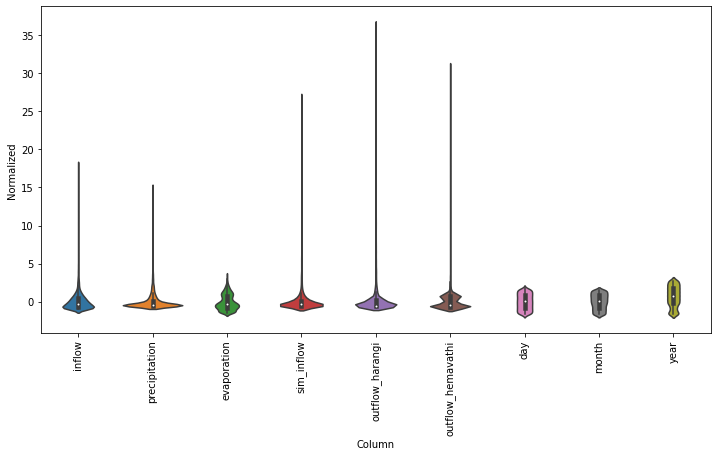

In [1458]:
#To-Do
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)
#Most data of inflow is concentrated, except seasonal peaks.

In [1459]:
#Windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift #maybe we should change this for when we have many outputs

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [1460]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT,
                     label_columns=['inflow'])
w1

Total window size: 366
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [1461]:
#split window into inputs and labels
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [1462]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 366, 9)
Inputs shape: (3, 365, 9)
labels shape: (3, 30, 1)


In [1463]:
w1.example = example_inputs, example_labels

In [1464]:
def plot(self, model=None, plot_col='inflow', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

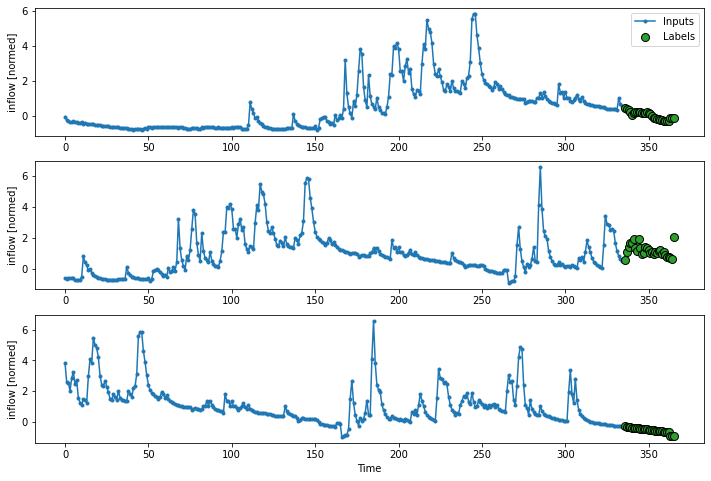

In [1465]:
w1.plot()

In [1466]:
def make_dataset(self, data, shuffle=True):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [1467]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df, shuffle=False) #important

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [1468]:
w1.train.element_spec

(TensorSpec(shape=(None, 365, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))

In [1469]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 365, 9)
Labels shape (batch, time, features): (32, 30, 1)


In [1470]:
#wide_window and wide_conv_window is just for display purposes, it doesn't change the model
wide_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH_DISPLAY, shift=SHIFT,
    label_columns=['inflow'])


for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

wide_window

Inputs shape (batch, time, features): (32, 365, 9)
Labels shape (batch, time, features): (32, 20, 1)


Total window size: 366
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

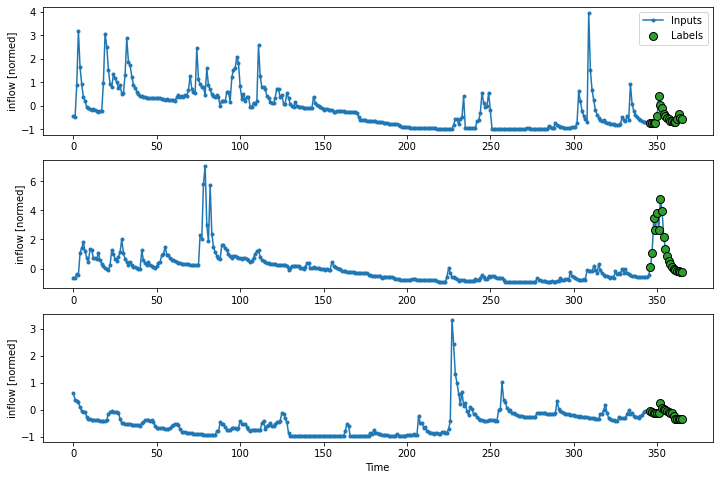

In [1471]:
wide_window.plot()

In [1472]:
conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    label_columns=['inflow'])

conv_window

Total window size: 366
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [1473]:
INPUT_WIDTH, LABEL_WIDTH, SHIFT

(365, 30, 1)

In [1474]:
#To-do: only for display. add plots for multiple outputs (wide window function)
print(LABEL_WIDTH_DISPLAY)
INPUT_WIDTH_NEW = LABEL_WIDTH_DISPLAY + (INPUT_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH_NEW,
    label_width=LABEL_WIDTH_DISPLAY,
    shift=SHIFT,
    label_columns=['inflow'])

wide_conv_window

20


Total window size: 385
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

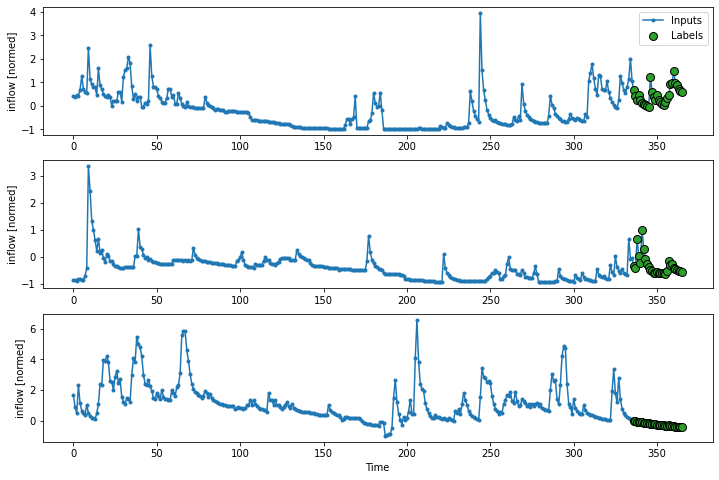

In [1475]:
conv_window.plot()

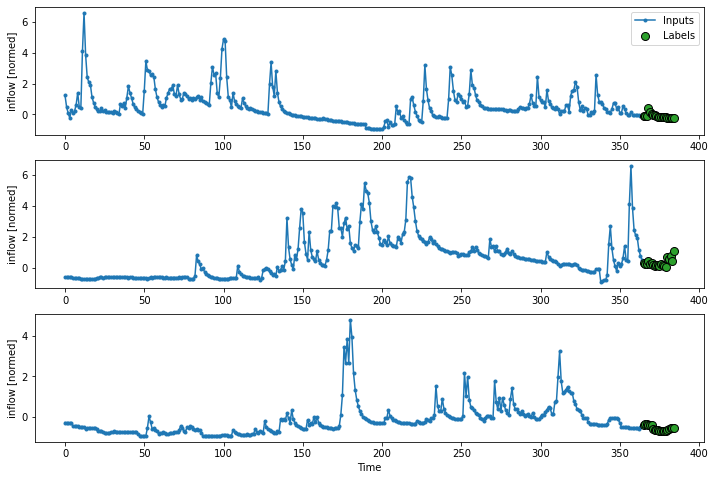

In [1476]:
wide_conv_window.plot()

In [1477]:
#to-do: build a baseline model (maybe simple auto-regressive model)
# build simpler models: linear, ARIMA, ...

# Learning Rate Optimization

In [1478]:
#LR-Finder (adopted from fast.ai)
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-8, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

lr_finder=LRFinder()

In [1479]:
#power scheduling learning rate. Didn't implement.

In [1480]:
#common function for all models
#for testing. keep epochs low, patience low (eg 50, 5). whent training keep high (eg. 5000, 15)
#MAX_EPOCHS = 30
#PATIENCE = 5 # stops training if overfitting. dont set it too low.

val_performance = {}
performance = {}
def compile_and_fit(model, window, patience=PATIENCE, is_earlystopping=False, is_lr_finder=False, is_cyclic_lr=True, max_epochs=MAX_EPOCHS):
  
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min')
    
    if is_cyclic_lr:
        model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=clr),
                metrics=[tf.metrics.MeanAbsoluteError(), 
                         #tf.metrics.MeanAbsolutePercentageError(), 
                         tf.metrics.RootMeanSquaredError()])
    else:
         model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), 
                         #tf.metrics.MeanAbsolutePercentageError(), 
                         tf.metrics.RootMeanSquaredError()])   
    
    callbacks=[]
    if is_lr_finder:
        if is_earlystopping:
            callbacks=[early_stopping, lr_finder]
        else:
            callbacks=[lr_finder]    
    
    if is_earlystopping:
        callbacks=[early_stopping]


    history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=callbacks)
    return history

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [1481]:
len(train_df)/32, conv_window

(72.125, Total window size: 366
 Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
  144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
  162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
  180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
  216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231

Epoch 1/30
61/61 [==============================] - 10s 32ms/step - loss: 2.1376 - mean_absolute_error: 0.6504 - root_mean_squared_error: 0.8949 - val_loss: 5.3192 - val_mean_absolute_error: 1.0178 - val_root_mean_squared_error: 2.0385
Epoch 2/30
61/61 [==============================] - 1s 11ms/step - loss: 5.5617 - mean_absolute_error: 0.6257 - root_mean_squared_error: 0.8966 - val_loss: 34.5836 - val_mean_absolute_error: 1.9428 - val_root_mean_squared_error: 2.6510


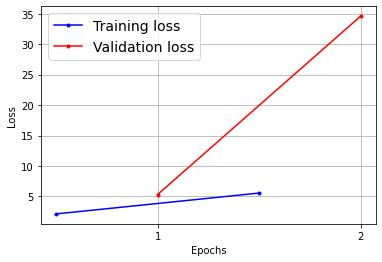

In [1482]:
# This model is only for testing learning rate
#DROPOUT=0.3
#RECURRENT_DROPOUT=0.3

# we change optimizer in compiler function to remove learning_rate=clr
lstm_cyclic_lr = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

history = compile_and_fit(lstm_cyclic_lr, conv_window, is_earlystopping=False, is_lr_finder=True, 
                          is_cyclic_lr=False)    


#IPython.display.clear_output()
plot_learning_curves(history.history['loss'], history.history['val_loss'])

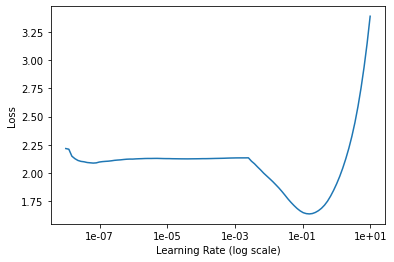

In [1483]:
lr_finder.plot()

In [1484]:
#Cyclic Learning Rate
!pip install tensorflow_addons
import tensorflow_addons as tfa
import math
MAX_LR=0.02 #from lr_finder graph. 1 order less than minima
MIN_LR=.002 # from lr_finder graph. 1/5th of max_lr
BATCH_SIZE=32
STEPS_PER_EPOCH=math.ceil(len(train_df)/BATCH_SIZE)#

def scale_fn(x):
    return 1/(2.**(x-1))

clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=MIN_LR,maximal_learning_rate=MAX_LR,
                                          scale_fn=scale_fn,
                                          step_size=2 * STEPS_PER_EPOCH
)

#It is usually used with SGD optimizer, but we are using with ADAM

In [1485]:
# step = np.arange(0,MAX_EPOCHS * 200)
# lr = clr(step)
# plt.plot(step, lr)
# plt.xlabel("Steps")
# plt.ylabel("Learning Rate")
# plt.show()


# Model Experimentation (Ignore)

In [ ]:
# # Model 0: ARIMA
# #!pip install pmdarima
# from pmdarima import auto_arima
  
# # Ignore harmless warnings
# import warnings
# warnings.filterwarnings("ignore")
  
# # Fit auto_arima function to AirPassengers dataset
# stepwise_fit = auto_arima(inputs['storage'], start_p = 1, start_q = 1,
#                           max_p = 3, max_q = 3, m = 12,
#                           start_P = 0, seasonal = True,
#                           d = None, D = 1, trace = True,
#                           error_action ='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings = True,  # we don't want convergence warnings
#                           stepwise = True)           # set to stepwise
  
# # To print the summary
# stepwise_fit.summary()


Best model:  ARIMA(2,0,0)(2,1,0)[12]          
Total fit time: 378.848 seconds

SARIMAX Results Dep. Variable: 	y 	No. Observations: 	3306
Model: 	SARIMAX(2, 0, 0)x(2, 1, 0, 12) 	Log Likelihood 	-6571.364
Date: 	Sat, 17 Jul 2021 	AIC 	13152.729
Time: 	04:08:47 	BIC 	13183.228
Sample: 	0 	HQIC 	13163.647
	- 3306 		
Covariance Type: 	opg 		
	coef 	std err 	z 	P>|z| 	[0.025 	0.975]
ar.L1 	0.6936 	0.002 	326.821 	0.000 	0.689 	0.698
ar.L2 	0.2822 	0.004 	72.697 	0.000 	0.275 	0.290
ar.S.L12 	-0.6670 	0.003 	-210.457 	0.000 	-0.673 	-0.661
ar.S.L24 	-0.3176 	0.003 	-98.993 	0.000 	-0.324 	-0.311
sigma2 	3.1570 	0.008 	381.105 	0.000 	3.141 	3.173
Ljung-Box (L1) (Q): 	0.12 	Jarque-Bera (JB): 	5238207.52
Prob(Q): 	0.73 	Prob(JB): 	0.00
Heteroskedasticity (H): 	0.17 	Skew: 	-4.50
Prob(H) (two-sided): 	0.00 	Kurtosis: 	198.15


Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [ ]:
# # Model 1: multi-step dense. (Fully-connected NN)
# multi_step_dense = tf.keras.Sequential([
#     # Shape: (time, features) => (time*features)
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=1),
#     # Add back the time dimension.
#     # Shape: (outputs) => (1, outputs)
#     tf.keras.layers.Reshape([1, -1]),
# ])

In [ ]:
# print('Input shape:', conv_window.example[0].shape)
# print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
# history = compile_and_fit(multi_step_dense, conv_window)

# IPython.display.clear_output()
# val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
# performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
# plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
#Model 2: Conv-dense. same model but more flexible for different input shapes.
DROPOUT=0.5
dense_nn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=(INPUT_WIDTH,),activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01) ),
    tf.keras.layers.Dropout(rate=DROPOUT),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)),
    tf.keras.layers.Dropout(rate=DROPOUT),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1, 1])

])

0.3

In [ ]:
print("Dense model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', dense_nn(conv_window.example[0]).shape)

Dense model on `conv_window`
Input shape: (32, 120, 7)
Output shape: (32, 30, 1)


18/18 [==============================] - 0s 6ms/step - loss: 4.4154 - mean_absolute_error: 0.6816 - mean_absolute_percentage_error: 226.0253 - root_mean_squared_error: 2.0828


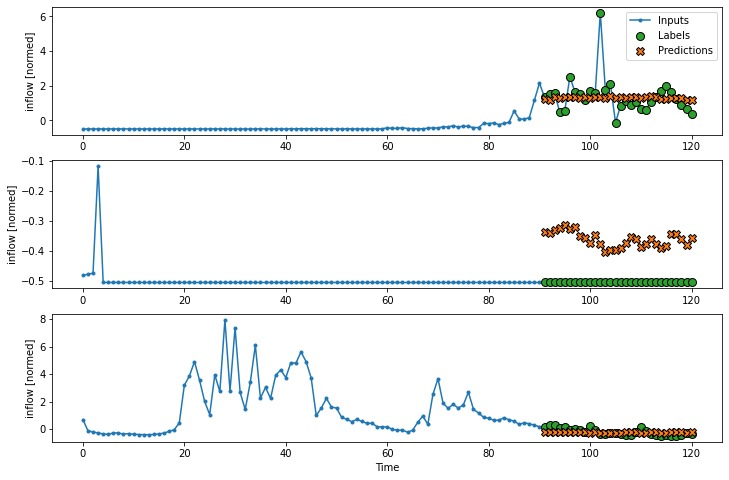

In [ ]:
history = compile_and_fit(dense_nn, conv_window)

IPython.display.clear_output()
val_performance['dense_nn'] = dense_nn.evaluate(conv_window.val)
performance['dense_nn'] = dense_nn.evaluate(conv_window.test, verbose=0)

conv_window.plot(dense_nn)

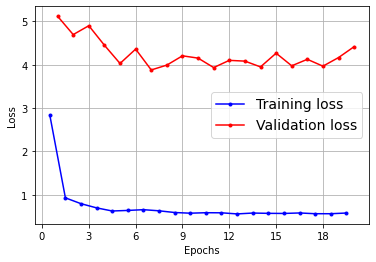

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
#dense_nn.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_dense_nn')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/krs_1_dense_nn/assets


In [ ]:
#wide_conv_window.plot(dense_nn)

In [ ]:
# Model 3: Recurrent Neural Network - LSTM (Simple)
lstm_basic = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001) ),#model outputs all intermediate predictions as well. If training a deep network, need this for all layers except the last
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1, 1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_basic(conv_window.example[0]).shape) #check output shape. should be (32, 1,1)

Input shape: (32, 120, 7)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(lstm_basic, conv_window, max_epochs=100)

IPython.display.clear_output()
val_performance['lstm_basic'] = lstm_basic.evaluate(conv_window.val)
performance['lstm_basic'] = lstm_basic.evaluate(conv_window.test, verbose=0)

18/18 [==============================] - 0s 5ms/step - loss: 2.2631 - mean_absolute_error: 0.4160 - mean_absolute_percentage_error: 127.4515 - root_mean_squared_error: 1.4971


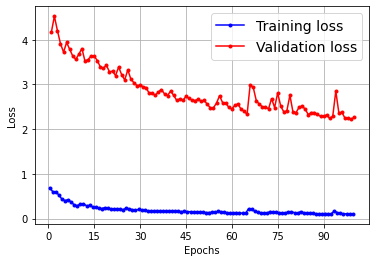

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

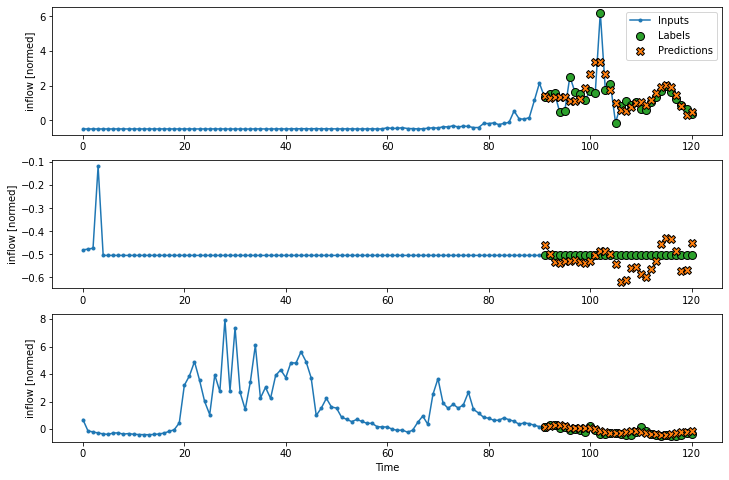

In [ ]:
conv_window.plot(lstm_basic)

In [ ]:
#lstm_basic.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_lstm_basic')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_basic/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_basic/assets


In [ ]:
# # Model 4: LSTM with Residual connections. (IMPLEMENTED WRONGLY> SKIP IT.)
# class ResidualWrapper(tf.keras.Model):
#   def __init__(self, model):
#     super().__init__()
#     self.model = model

#   def call(self, inputs, *args, **kwargs):
#     delta = self.model(inputs, *args, **kwargs)

#     # The prediction for each timestep is the input
#     # from the previous time step plus the delta
#     # calculated by the model.
#     return inputs + delta

In [ ]:
# residual_lstm = ResidualWrapper(
#     tf.keras.Sequential([
#     tf.keras.layers.LSTM(32, return_sequences=True),
#     tf.keras.layers.Dense(
#         num_features,
#         # The predicted deltas should start small
#         # So initialize the output layer with zeros
#         kernel_initializer=tf.initializers.zeros()),
#     tf.keras.layers.Dense(1)  #dont know if last layer should be added  
# ]))


In [ ]:
# print('Input shape:', conv_window.example[0].shape)
# print('Output shape:', residual_lstm(conv_window.example[0]).shape) #check output shape. should be (32, 1,1)


In [ ]:

# history = compile_and_fit(residual_lstm, conv_window)

# IPython.display.clear_output()
# val_performance['residual_lstm'] = residual_lstm.evaluate(conv_window.val)
# performance['residual_lstm'] = residual_lstm.evaluate(conv_window.test, verbose=0)

In [ ]:
# residual_lstm.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_residual_lstm')

In [ ]:
#take it deeper
#add layer norm
#add conv layer
#add dropout, recurrent_dropout. May also evaluate uncertainty using Monte-Carlo Dropout
#try WaveNet
#try bi-directional LSTM, GRU
#add cross-batch statefulness

In [ ]:
# # Model 5: Deep LSTM
# !pip install tensorflow_addons
# import tensorflow_addons as tfa
# lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32) 


# deep_lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
#     tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
#     tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
#     #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

In [ ]:
# print('Input shape:', conv_window.example[0].shape)
# print('Output shape:', deep_lstm_model(conv_window.example[0]).shape)
# #expected (32, 1, 1). It is because of return_sequences=True and Conv1D

In [ ]:
# history = compile_and_fit(deep_lstm_model, conv_window)

# IPython.display.clear_output()
# val_performance['Deep_LSTM'] = deep_lstm_model.evaluate(conv_window.val)
# performance['Deep_LSTM'] = deep_lstm_model.evaluate(conv_window.test, verbose=0)

In [ ]:
# plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
#Model 6: Deep LSTM with Conv; without Layer Normalization
deep_lstm_model_2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', deep_lstm_model_2(conv_window.example[0]).shape)


In [ ]:
history = compile_and_fit(deep_lstm_model_2, conv_window)

IPython.display.clear_output()
val_performance['Deep_LSTM_2'] = deep_lstm_model_2.evaluate(wide_window.val)
performance['Deep_LSTM_2'] = deep_lstm_model_2.evaluate(wide_window.test, verbose=0)

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# Model 7: WaveNet
wavenet = tf.keras.models.Sequential()
wavenet.add(tf.keras.layers.Conv1D(filters=20, kernel_size=INPUT_WIDTH, strides=2, padding='valid'))
#wavenet.add(tf.keras.layers.InputLayer(input_shape=[None, 7]))# explicitly telling input shape. [None, #features]
for rate in (1, 2, 4, 8, 16, 32) * 2:
    wavenet.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001) ))
wavenet.add(tf.keras.layers.Conv1D(filters=10, kernel_size=1))
wavenet.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)))
wavenet.add(tf.keras.layers.Reshape([-1,1]))

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', wavenet(conv_window.example[0]).shape) #check shape. should be (32, 1, 1)

Input shape: (32, 120, 7)
Output shape: (32, 30, 1)


In [ ]:
#wavenet.summary()

In [ ]:
history = compile_and_fit(wavenet, conv_window)

IPython.display.clear_output()
val_performance['wavenet'] = wavenet.evaluate(conv_window.val)
performance['wavenet'] = wavenet.evaluate(conv_window.test, verbose=0)

18/18 [==============================] - 0s 5ms/step - loss: 6.4628 - mean_absolute_error: 1.0318 - mean_absolute_percentage_error: 105.1776 - root_mean_squared_error: 2.5412


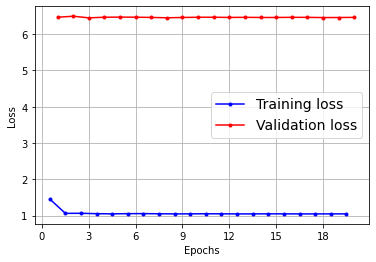

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
#wavenet.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_wavenet')

In [ ]:
# Model 8: LSTM with dropout (becasue all the above models seem to overfit)
DROPOUT=0.5
RECURRENT_DROPOUT=0.5

lstm_deep_1 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_deep_1(conv_window.example[0]).shape)


Input shape: (32, 120, 7)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(lstm_deep_1, conv_window)

IPython.display.clear_output()
val_performance['lstm_deep_1'] = lstm_deep_1.evaluate(conv_window.val)
performance['lstm_deep_1'] = lstm_deep_1.evaluate(conv_window.test, verbose=0)

18/18 [==============================] - 0s 5ms/step - loss: 4.7268 - mean_absolute_error: 0.6732 - mean_absolute_percentage_error: 223.7565 - root_mean_squared_error: 2.1741


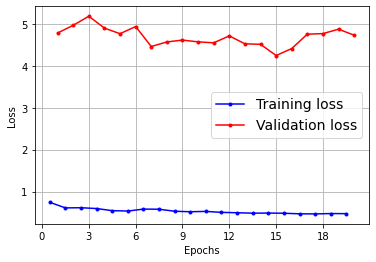

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
#lstm_deep_1.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_lstm_deep_1')

In [ ]:
# Model 9: LSTM with dropout, conv, layer norm
DROPOUT=0.3
RECURRENT_DROPOUT=0.3
#!pip install tensorflow_addons
import tensorflow_addons as tfa
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)) 
lstm_deep_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True,  ),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True, ),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True, ),
    #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_deep_2(conv_window.example[0]).shape)


Input shape: (32, 120, 7)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(lstm_deep_2, conv_window)

IPython.display.clear_output()
val_performance['lstm_deep_2'] = lstm_deep_2.evaluate(conv_window.val)
performance['lstm_deep_2'] = lstm_deep_2.evaluate(conv_window.test, verbose=0)

18/18 [==============================] - 0s 6ms/step - loss: 4.3919 - mean_absolute_error: 0.6326 - mean_absolute_percentage_error: 166.1165 - root_mean_squared_error: 2.0764


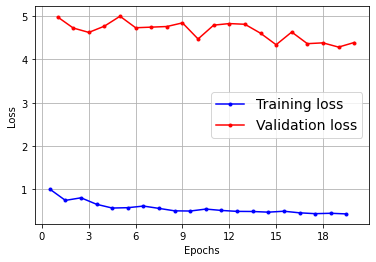

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
#lstm_deep_2.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_lstm_deep_2')

In [ ]:
#wide_conv_window.plot(lstm_deep_2)

In [ ]:
# Model: Very Deep LSTM
DROPOUT=0.3
RECURRENT_DROPOUT=0.3
#!pip install tensorflow_addons
import tensorflow_addons as tfa
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, 
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)) 
lstm_deep_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    
    #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_deep_3(conv_window.example[0]).shape)

Input shape: (32, 365, 7)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(lstm_deep_3, conv_window)

IPython.display.clear_output()
val_performance['lstm_deep_3'] = lstm_deep_3.evaluate(conv_window.val)
performance['lstm_deep_3'] = lstm_deep_3.evaluate(conv_window.test, verbose=0)

5/5 [==============================] - 0s 12ms/step - loss: 0.4548 - mean_absolute_error: 0.2647 - root_mean_squared_error: 0.4165


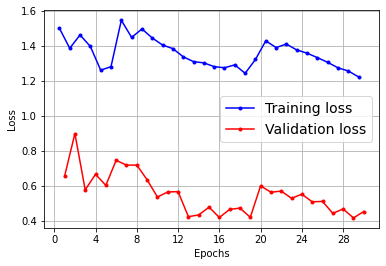

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
#lstm_deep_3.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_lstm_deep_3')

#Final Model and Ensemble Model (Monte-Carlo Dropout)

In [1486]:
tf.random.set_seed(42) #For reproducibility
np.random.seed(42)

In [1487]:
# This model is only for testing hyperparameters - dropout, kernel_regulaizer, etc,
#RANGE Tested
# DROPOUT=0.2
# RECURRENT_DROPOUT=0.2

if INPUT_WIDTH>=300: # We prefer a simpler model for long-timeseries.
    lstm_no_mc = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=20, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
 #   Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

else:
    lstm_no_mc = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=20, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
 #   Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

# we change optimizer in compiler function to remove learning_rate=clr
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_no_mc(conv_window.example[0]).shape)

history = compile_and_fit(lstm_no_mc, conv_window, max_epochs=5)    
IPython.display.clear_output()

In [1488]:
#lstm_no_mc.summary()

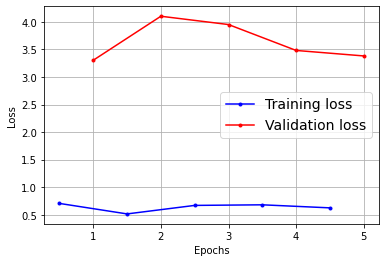

In [1489]:
#final plot
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [1490]:
#history = compile_and_fit(lstm_no_mc, conv_window, max_epochs=40)
#plot_learning_curves(history.history['loss'], history.history['val_loss']) #l2 0.001 1 layer

In [1491]:
#plot_learning_curves(history.history['loss'], history.history['val_loss']) # 3 layers

In [1492]:
#plot_learning_curves(history.history['loss'], history.history['val_loss'])# 1 layer . dropout

In [1493]:
#plot_learning_curves(history.history['loss'], history.history['val_loss']) #2 dropout layers

In [1494]:
#plot_learning_curves(history.history['loss'], history.history['val_loss']) #2 dropout layers. l2=0

In [1495]:
#plot_learning_curves(history.history['loss'], history.history['val_loss']) #1 dropout layers l2=0

In [1496]:
#history = compile_and_fit(lstm_no_mc, conv_window, max_epochs=100)
#plot_learning_curves(history.history['loss'], history.history['val_loss']) #65-20-15 split

In [1497]:
#plot_learning_curves(history.history['loss'], history.history['val_loss']) #65-20-15 split. 3 layres.

In [1498]:
conv_window.train, conv_window.val, conv_window.test

(<MapDataset shapes: ((None, 365, 9), (None, 30, 1)), types: (tf.float32, tf.float32)>,
 <MapDataset shapes: ((None, 365, 9), (None, 30, 1)), types: (tf.float32, tf.float32)>,
 <MapDataset shapes: ((None, 365, 9), (None, 30, 1)), types: (tf.float32, tf.float32)>)

In [1499]:
class MonteCarloLSTM(tf.keras.layers.LSTM):
   def call(self, inputs):
      return super().call(inputs, training=True)

In [1500]:
#DROPOUT=0.3
#RECURRENT_DROPOUT=0.3

# we change optimizer in compiler function to remove learning_rate=clr
if INPUT_WIDTH>=300:
    lstm_mc = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    MonteCarloLSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])
else:
    lstm_mc = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    MonteCarloLSTM(units=32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    MonteCarloLSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    MonteCarloLSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])



print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_mc(conv_window.example[0]).shape)

history = compile_and_fit(lstm_mc, conv_window)
IPython.display.clear_output()

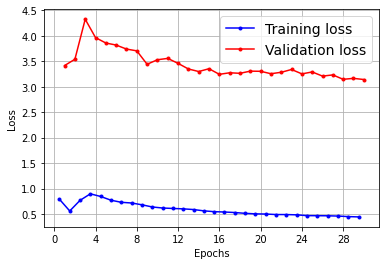

In [1501]:
#Final Plot
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

In [1502]:
lstm_mc.summary(), DROPOUT, RECURRENT_DROPOUT, l1_reg, l2_reg

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 1, 32)             105152    
_________________________________________________________________
monte_carlo_lstm_34 (MonteCa (None, 1, 32)             8320      
_________________________________________________________________
time_distributed_44 (TimeDis (None, 1, 30)             990       
_________________________________________________________________
reshape_44 (Reshape)         (None, 30, 1)             0         
Total params: 114,462
Trainable params: 114,462
Non-trainable params: 0
_________________________________________________________________


(None, 0.3, 0.3, 0.001, 0.001)

In [1503]:
#plot_learning_curves(history.history['loss'], history.history['val_loss']) #l2=0

In [1504]:
#plot_learning_curves(history.history['loss'], history.history['val_loss']) #with l2=0.001

In [1505]:
#plot_learning_curves(history.history['loss'], history.history['val_loss']) #65-20-15 split

In [1506]:
lstm_mc.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_lstm_mc')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/krs_365_30_lstm_mc/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/krs_365_30_lstm_mc/assets


In [1507]:
for i in range(5):
    a=lstm_no_mc.predict(conv_window.test)
    print(a[0][2])

[0.0164731]
[0.0164731]
[0.0164731]
[0.0164731]
[0.0164731]


In [1508]:
for i in range(5):
    a=lstm_mc.predict(conv_window.test)
    print(a[0][2])

[0.1120865]
[-0.20625308]
[-0.18532205]
[-0.22020963]
[0.15284741]


In [1509]:
for inputs, labels in conv_window.test.take(-1):
    print(inputs.shape, labels.shape)

(32, 365, 9) (32, 30, 1)
(32, 365, 9) (32, 30, 1)
(32, 365, 9) (32, 30, 1)
(32, 365, 9) (32, 30, 1)
(32, 365, 9) (32, 30, 1)
(32, 365, 9) (32, 30, 1)
(32, 365, 9) (32, 30, 1)
(32, 365, 9) (32, 30, 1)
(32, 365, 9) (32, 30, 1)
(32, 365, 9) (32, 30, 1)
(10, 365, 9) (10, 30, 1)


In [1510]:
DAM

'krs'

# Saving Predictions

In [1511]:
class MonteCarloLSTM(tf.keras.layers.LSTM):
   def call(self, inputs):
      return super().call(inputs, training=True)

In [1512]:
#model_list=['dense_nn', 'lstm_basic','wavenet','lstm_deep_1', 'lstm_deep_2', 'lstm_deep_3'] #SINGLE PREDICTIONS

model_list=[f'{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_lstm_mc'] #ENSEMBLE PREDICTIONS
#Run everything except models block to run this block. (Run Learning Rate Optimizers as well)
model_list

['krs_365_30_lstm_mc']

In [1513]:
#FOR ENSEMBLE PREDICTIONS
ENSEMBLE_SIZE=50

labels_f=[]
inputs_f=[]
predictions_f=[] 

for models in model_list:
    model=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{models}',
                                     custom_objects={"scale_fn": scale_fn, 'MonteCarloLSTM': MonteCarloLSTM})
    
    for j in range(ENSEMBLE_SIZE):
        predictions=model.predict(conv_window.test)
        predictions=predictions*train_std[0]+train_mean[0] #unnormalize
        predictions_f.append(predictions)
    predictions_f=np.array(predictions_f)

    i=0
    for inputs, labels in conv_window.test.take(-1):

    #print(inputs.shape, labels.shape, i)
        if i==0:
            inputs_f=inputs
            labels_f=labels
        else:
            inputs_f=tf.concat([inputs_f, inputs], axis=0)
            labels_f=tf.concat([labels_f, labels], axis=0)
        i +=1

    #un-normalize
    labels_f=labels_f*train_std[0]+train_mean[0]
    inputs_f=inputs_f*train_std+train_mean

    #mean and variance
    predictions_mean=predictions_f.mean(axis=0)
    predictions_std=predictions_f.std(axis=0)

In [1514]:
predictions_f.shape, predictions_mean.shape, labels_f.shape

((50, 330, 30, 1), (330, 30, 1), TensorShape([330, 30, 1]))

In [1515]:
#model.get_config(), model.summary()
conv_window.test

<MapDataset shapes: ((None, 365, 9), (None, 30, 1)), types: (tf.float32, tf.float32)>

In [1516]:
inputs_f=inputs_f.numpy()
labels_f=labels_f.numpy()

day_index=conv_window.column_indices['day']
month_index=conv_window.column_indices['month']
year_index=conv_window.column_indices['year']
print(day_index, month_index, year_index)

from datetime import datetime, timedelta
BATCH_SIZE=predictions_mean.shape[0]
date_f=[]
print(BATCH_SIZE)
for i in range(BATCH_SIZE): #for each batch i
    for j in range(LABEL_WIDTH): #LABEL_WIDTH
        #print(i)
        #input_start_date=datetime(year=round(inputs_f[i][0][year_index]), month=round(inputs_f[i][0][month_index]), day=round(inputs_f[i][0][day_index]))
        input_end_date=datetime(year=round(inputs_f[i][-1][year_index]), month=round(inputs_f[i][-1][month_index]), day=round(inputs_f[i][-1][day_index]))
        pred_date=input_end_date+timedelta(days=j+1)
        #pred_start_date=input_end_date+timedelta(days=1)
        #pred_end_date=input_end_date+timedelta(days=LABEL_WIDTH)
        date_f.append(pred_date)
        #print(pred_date)
        #print(input_start_date, input_end_date, pred_start_date, pred_end_date, pred_date)
date_f=np.array(date_f)
date_f=np.reshape(date_f, newshape=(BATCH_SIZE, LABEL_WIDTH, 1))
print(date_f.shape)
print(date_f[0:2, :, :])
print(date_f[:-1, :, :])


6 7 8
330
(330, 30, 1)
[[[datetime.datetime(2020, 1, 1, 0, 0)]
  [datetime.datetime(2020, 1, 2, 0, 0)]
  [datetime.datetime(2020, 1, 3, 0, 0)]
  [datetime.datetime(2020, 1, 4, 0, 0)]
  [datetime.datetime(2020, 1, 5, 0, 0)]
  [datetime.datetime(2020, 1, 6, 0, 0)]
  [datetime.datetime(2020, 1, 7, 0, 0)]
  [datetime.datetime(2020, 1, 8, 0, 0)]
  [datetime.datetime(2020, 1, 9, 0, 0)]
  [datetime.datetime(2020, 1, 10, 0, 0)]
  [datetime.datetime(2020, 1, 11, 0, 0)]
  [datetime.datetime(2020, 1, 12, 0, 0)]
  [datetime.datetime(2020, 1, 13, 0, 0)]
  [datetime.datetime(2020, 1, 14, 0, 0)]
  [datetime.datetime(2020, 1, 15, 0, 0)]
  [datetime.datetime(2020, 1, 16, 0, 0)]
  [datetime.datetime(2020, 1, 17, 0, 0)]
  [datetime.datetime(2020, 1, 18, 0, 0)]
  [datetime.datetime(2020, 1, 19, 0, 0)]
  [datetime.datetime(2020, 1, 20, 0, 0)]
  [datetime.datetime(2020, 1, 21, 0, 0)]
  [datetime.datetime(2020, 1, 22, 0, 0)]
  [datetime.datetime(2020, 1, 23, 0, 0)]
  [datetime.datetime(2020, 1, 24, 0, 0)]
  

In [1517]:
print(labels_f.shape, predictions_mean.shape, predictions_std.shape, date_f.shape) #all should be same

(330, 30, 1) (330, 30, 1) (330, 30, 1) (330, 30, 1)


In [1518]:
#Saving
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_labels',labels_f)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_mean',predictions_mean)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_std',predictions_std)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_dates',date_f)

In [1519]:
INPUT_WIDTH

365

In [1520]:
#FUTURE PREDICTIONS
input_array=test_df.to_numpy()
a=input_array.shape[0]
input_array=input_array[a-INPUT_WIDTH:]
b=input_array.shape
input_array=input_array.reshape((1,b[0],b[1]))

#FUTURE Predictions
predictions_future_f=[]
for j in range(ENSEMBLE_SIZE):
    predictions=model.predict(input_array)
    predictions=predictions*train_std[0]+train_mean[0] #unnormalize
    predictions_future_f.append(predictions)
predictions_future_f=np.array(predictions_future_f)


future_date_f=[]
for j in range(LABEL_WIDTH): #LABEL_WIDTH
        pred_date=LAST_DATE+timedelta(days=j+1)
        future_date_f.append(pred_date)

#mean and variance
predictions_future_mean=predictions_future_f.mean(axis=0)
predictions_future_std=predictions_future_f.std(axis=0)

np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_predictions_mean',predictions_future_mean)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_predictions_std',predictions_future_std)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_prediction_dates',future_date_f)
print(predictions_future_mean.shape, future_date_f)

(1, 30, 1) [Timestamp('2020-12-17 00:00:00'), Timestamp('2020-12-18 00:00:00'), Timestamp('2020-12-19 00:00:00'), Timestamp('2020-12-20 00:00:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2020-12-27 00:00:00'), Timestamp('2020-12-28 00:00:00'), Timestamp('2020-12-29 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-03 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-09 00:00:00'), Timestamp('2021-01-10 00:00:00'), Timestamp('2021-01-11 00:00:00'), Timestamp('2021-01-12 00:00:00'), Timestamp('2021-01-13 00:00:00'), Timestamp('2021-01-14 00:00:00'), Ti

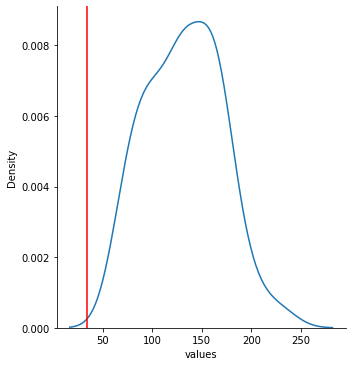

In [1521]:
#How a sample looks like
predictions_f_no_mc=lstm_no_mc.predict(conv_window.test)
predictions_f_no_mc=predictions_f_no_mc*train_std[0]+train_mean[0]

import matplotlib.pyplot as plt
g= sns.displot(data=predictions_f[:,10,-1,0], kind='kde')
g = g.set_axis_labels("values","Density")

#set(xlim=(275,295),ylim=(0,1)))
plt.axvline(predictions_f_no_mc[10,-1,0], c='r')
#plt.axvline(valid_diff.t.sel(time='2017-01-04T12').isel(lat=16, lon=0), c='r')
#plt.title("MC Dropout Forecast")
#plt.legend(('ensemble', 'truth'), loc='center left')
#plt.show()

In [1522]:
print(predictions_f.shape, predictions_f[:,10,-1,0].shape)
print(predictions_f_no_mc[10,-1,0], predictions_f[:,10,-1,0])

(50, 330, 30, 1) (50,)
34.563995 [121.334915  95.97127  164.64554  158.64363  144.5998   159.8257
 137.55542  101.446396 136.48409   87.863144  73.09578  193.0596
 148.05823  105.93468  105.730576  79.49716  203.2374   124.67374
 126.68771  169.61046   86.03491   71.843216 167.16205   95.68344
 229.48676  125.79309  132.5518   134.51868   72.29588  166.78139
 132.42891   93.46564  121.54869  130.69887  182.13013   68.98161
 164.01439  104.79645  179.96179  164.33427  158.05124  127.78914
 100.31825  133.13145  163.54526  156.27655   93.73262  158.43591
  72.81769  169.40927 ]


In [1523]:
# conv_window
# print(inputs_f.shape, labels_f.shape, conv_window.column_indices)
# print(inputs_f[0][-1][4:7]) #date, month, year
# print(inputs_f[0][-1][0], labels_f[0][-2][0]) #should be same
# inputs_f_2=inputs_f.numpy()
# from datetime import datetime, timedelta
# for i in range(40):
#     date = datetime(year=round(inputs_f_2[0][i][6]), month=round(inputs_f_2[0][i][5]), day=round(inputs_f_2[0][i][4]))
#     print(date)
# for i in range(5): #for each batch i
#     input_start_date=datetime(year=round(inputs_f_2[i][0][6]), month=round(inputs_f_2[i][0][5]), day=round(inputs_f_2[i][0][4]))
#     input_end_date=datetime(year=round(inputs_f_2[i][-1][6]), month=round(inputs_f_2[i][-1][5]), day=round(inputs_f_2[i][-1][4]))
#     pred_start_date=input_end_date+timedelta(days=1)
#     pred_end_date=input_end_date+timedelta(days=LABEL_WIDTH)
#     print(input_start_date, input_end_date, pred_start_date, pred_end_date)

In [1524]:
# print(labels_f.shape, predictions.shape)
# print(' sample truth: ', labels_f[0:5][-1], ' predictions ', predictions[0:5][-1], inputs)    

In [1525]:
# #for finding labels dates.
# conv_window = WindowGenerator(
#     input_width=INPUT_WIDTH,
#     label_width=LABEL_WIDTH,
#     shift=SHIFT,
#     )

# print(conv_window)


# sample_nn = tf.keras.Sequential([
#     tf.keras.layers.Conv1D(filters=32,kernel_size=(INPUT_WIDTH,),activation='relu'),
#     tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001) ),
#     tf.keras.layers.Dropout(rate=DROPOUT),
#     tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)),
#     tf.keras.layers.Dropout(rate=DROPOUT),
#     tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)),
#     tf.keras.layers.Dense(units=7),
# ])

# print("Dense model on `conv_window`")
# print('Input shape:', conv_window.example[0].shape)
# print('Output shape:', sample_nn(conv_window.example[0]).shape)

# history = compile_and_fit(sample_nn, conv_window)

In [1526]:
    # predictions=sample_nn.predict(conv_window.test)

    # #getting truth_value
    # inputs_f=[]
    # labels_f=[]
    # i=0
    # for inputs, labels in conv_window.test.take(-1):

    #     print(inputs.shape, labels.shape, i)
    #     if i==0:
    #         inputs_f=inputs
    #         labels_f=labels
    #     else:
    #         inputs_f=tf.concat([inputs_f, inputs], axis=0)
    #         labels_f=tf.concat([labels_f, labels], axis=0)
    #     i +=1

    # #un-normalize
    # #predictions=predictions*train_std+train_mean
    # labels_f=labels_f*train_std+train_mean
    # inputs_f=inputs_f*train_std+train_mean

    # #reshape, store
    # #labels_f=labels_f.numpy().reshape(-1)
    # #predictions=predictions.reshape(-1)
    # #print(labels_f.shape, predictions.shape)
    # #print('model: ', models, ' sample truth: ', labels_f[0:5], ' predictions ', predictions[0:5])

In [1527]:
# labels_f=labels_f*train_std+train_mean
# inputs_f=inputs_f*train_std+train_mean


In [1528]:
# inputs_f[-1,:,4:7]
# labels_f[:,:,4:6]
# for models in model_list:
#     model=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_{models}',
#                                      custom_objects={"scale_fn": scale_fn})
#     predictions=model.predict(conv_window.test)

#     #getting truth_value
#     #inputs_f=[]
#     labels_f=[]
#     i=0
#     for _, labels in conv_window.test.take(-1):

#         #print(inputs.shape, labels.shape, i)
#         if i==0:
#             #inputs_f=inputs
#             labels_f=labels
#         else:
#             #inputs_f=tf.concat([inputs_f, inputs], axis=0)
#             labels_f=tf.concat([labels_f, labels], axis=0)
#         i +=1

#     #un-normalize
#     predictions=predictions*train_std[0]+train_mean[0]
#     labels_f=labels_f*train_std[0]+train_mean[0]

#     #reshape, store
#     labels_f=labels_f.numpy().reshape(-1)
#     predictions=predictions.reshape(-1)
#     print(labels_f.shape, predictions.shape)
#     print('model: ', models, ' sample truth: ', labels_f[0:5], ' predictions ', predictions[0:5])
#     df = pd.DataFrame({"true" : labels_f, "prediction" : predictions})
#     df.to_csv(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/predictions/{DAM}_{SHIFT}_{models}_predictions.csv', index=False)

# #need to recheck why sample_truth is different in both



# Performance and Visualizations

In [1529]:
labels=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_labels.npy')
predictions_mean=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_mean.npy')
labels.shape, predictions_mean.shape

((330, 30, 1), (330, 30, 1))

In [1530]:
mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
mse2=mse.numpy()
print(mse2.mean(), DAM, INPUT_WIDTH, LABEL_WIDTH, labels.shape, predictions_mean.shape) #test set = from (90%-INPUT_WIDTH) to 100%

64923.023 krs 365 30 (330, 30, 1) (330, 30, 1)


In [1329]:
mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
mse2=mse.numpy()
print(mse2.mean(), DAM, INPUT_WIDTH, LABEL_WIDTH, labels.shape, predictions_mean.shape) #test set = from (90%-INPUT_WIDTH) to 100%

33052.02 krs 300 30 (330, 30, 1) (330, 30, 1)


In [210]:
mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
mse2=mse.numpy()
print(mse2.mean(), DAM, INPUT_WIDTH, LABEL_WIDTH, label1.shape, prediction1.shape) 

NameError: ignored

In [ ]:
mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
mse2=mse.numpy()
print(mse2.mean(), DAM, INPUT_WIDTH, LABEL_WIDTH, labels.shape, predictions_mean.shape) 

In [ ]:
mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
mse2=mse.numpy()
print(mse2.mean(), DAM, INPUT_WIDTH, LABEL_WIDTH, labels.shape, predictions_mean.shape) #300 epochs

In [ ]:
#kabini

mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
mse2=mse.numpy()
print(mse2.mean(), DAM, INPUT_WIDTH, LABEL_WIDTH, labels.shape, predictions_mean.shape) #30 epochs

In [ ]:
#hemavathi

mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
mse2=mse.numpy()
print(mse2.mean(), DAM, INPUT_WIDTH, LABEL_WIDTH, labels.shape, predictions_mean.shape) #30 epochs

In [1531]:
#KRS

mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
mse2=mse.numpy()
print(mse2.mean(), DAM, INPUT_WIDTH, LABEL_WIDTH, labels.shape, predictions_mean.shape) #30 epochs

64923.023 krs 365 30 (330, 30, 1) (330, 30, 1)


In [ ]:
# model_list=['dense_nn', 'lstm_basic', 'wavenet', 'lstm_deep_1', 'lstm_deep_2', 'lstm_deep_3']
# model_list=[f'{INPUT_WIDTH}_{LABEL_WIDTH}_lstm_mc']
# for models in model_list:
#     print(models)
#     model=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{models}',
#                                      custom_objects={"scale_fn": scale_fn})
#     val_performance[models] = model.evaluate(conv_window.val)
#     performance[models] = model.evaluate(conv_window.test, verbose=0)


In [ ]:
# x = np.arange(len(performance))
# width = 0.3

# metric_name = 'mean_absolute_error'
# metric_index = lstm_deep_2.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance.keys(),
#            rotation=45)
# plt.ylabel('MAE (average over all outputs)')
# _ = plt.legend()

In [ ]:
# x = np.arange(len(performance))
# width = 0.3

# metric_name = 'mean_absolute_percentage_error'
# metric_index = lstm_deep_2.metrics_names.index('mean_absolute_percentage_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance.keys(),
#            rotation=45)
# plt.ylabel('MAPE (average over all outputs)')
# _ = plt.legend()

In [ ]:
# x = np.arange(len(performance))
# width = 0.3

# metric_name = 'root_mean_squared_error'
# metric_index = lstm_deep_2.metrics_names.index('root_mean_squared_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance.keys(),
#            rotation=45)
# plt.ylabel('RMSE (average over all outputs)')
# _ = plt.legend()

# Heatmap

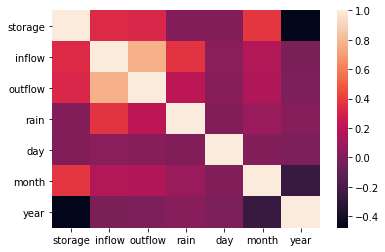

In [ ]:
corr = train_df.corr()
sns.heatmap(corr)

# SHAP Values (Ignore)

In [ ]:
#getting truth_value
test_df3=[]
train_df3=[]
i=0
for _, labels in conv_window.test.take(-1):
    #print(inputs.shape, i)
    if i==0:
        test_df3=labels
    else:
        test_df3=tf.concat([test_df3, labels], axis=0)
    i +=1

i=0
for inputs, _ in conv_window.train.take(-1):
    #print(inputs.shape, i)
    if i==0:
        train_df3=inputs
    else:
        train_df3=tf.concat([train_df3, inputs], axis=0)
    i +=1


test_df3=test_df3.numpy()
train_df3=train_df3.numpy()
test_df3.shape, train_df3.shape #shap only accepts numpy array

((93, 1, 1), (1724, 90, 7))

In [ ]:
# #getting truth_value
# test_df3=[]
# train_df3=[]
# i=0
# for inputs, _ in conv_window.test.take(-1):
#     #print(inputs.shape, i)
#     if i==0:
#         test_df3=inputs
#     else:
#         test_df3=tf.concat([test_df3, inputs], axis=0)
#     i +=1

# i=0
# for inputs, _ in conv_window.train.take(-1):
#     #print(inputs.shape, i)
#     if i==0:
#         train_df3=inputs
#     else:
#         train_df3=tf.concat([train_df3, inputs], axis=0)
#     i +=1


# test_df3=test_df3.numpy()
# train_df3=train_df3.numpy()
# test_df3.shape, train_df3.shape #shap only accepts numpy array

((93, 90, 7), (1724, 90, 7))

In [ ]:
tf.compat.v1.disable_v2_behavior() #may cause MANY troubles, but sadly SHAP isn't fully compatible with Tensorflow 2.x.
#In general, run SHAP after you've done everything above. If you want to re-run codes with 2.x, do a factory reset runtime.

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
model_list=['lstm_deep_1']
for models in model_list:
    print(models)
    model=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_{models}',
                                     custom_objects={"scale_fn": scale_fn})
    model.add(tf.keras.layers.Reshape(target_shape=(1,))) #shap only accepts single number or vector


lstm_deep_1


In [ ]:
# preds=model.predict(conv_window.test)
# print(model.output_shape, preds.shape, train_df.shape, test_df.shape)
# #model.add(tf.keras.layers.Reshape(target_shape=(1,)))
# #preds=model.predict(conv_window.test)
# #model.output_shape, preds.shape, train_df.shape, test_df.shape
# type(model), type(test_df)
# #test_df2=test_df.to_numpy()
# #train_df2=train_df.to_numpy()
# #test_df2.shape, train_df2.shape
# #conv_window.train      #input,          output

In [ ]:
!pip install shap
import shap
explainer = shap.DeepExplainer(model, train_df3)
shap_values = explainer.shap_values(test_df3)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


ValueError: ignored

In [ ]:
explainer.expected_value, np.array(shap_values).shape, train_df.columns, train_df3.shape, test_df3.shape

(array([-0.1221296], dtype=float32),
 (1, 93, 90, 7),
 Index(['storage', 'inflow', 'outflow', 'rain', 'day', 'month', 'year'], dtype='object'),
 (1724, 90, 7),
 (93, 90, 7))

In [ ]:
#For a Single Prediction
shap.initjs() # init the JS visualization code. #in google colab, in every cell you need a visualization, you'll need to call initjs()
shap.force_plot(explainer.expected_value, shap_values[0][42][:][:], test_df3[42][:][:], train_df.columns)

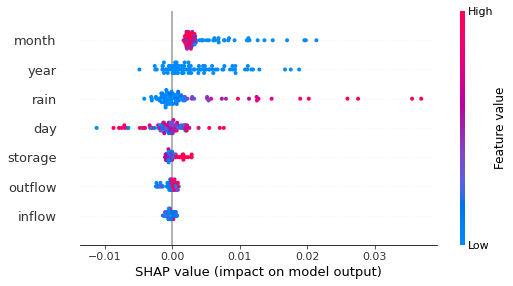

In [ ]:
shap.summary_plot(shap_values[0][:][10][:], test_df3[:][10][:], train_df.columns)

AttributeError: ignored

# Testing (Ignore)

In [ ]:
# dense_nn=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_dense_nn')

In [ ]:
predictions=lstm_no_mc.predict(conv_window.test)
predictions.shape

(232, 10, 1)

In [ ]:
predictions[0:2,0,0]

array([-0.5387033, -0.5540465], dtype=float32)

In [ ]:
conv_window.column_indices

{'day': 4,
 'inflow': 1,
 'month': 5,
 'outflow': 2,
 'rain': 3,
 'storage': 0,
 'year': 6}

In [ ]:
inputs_f=[]
labels_f=[]
i=0
for inputs, labels in conv_window.test.take(-1):

    print(inputs.shape, labels.shape, i)
    if i==0:
        inputs_f=inputs
        labels_f=labels
    else:
        inputs_f=tf.concat([inputs_f, inputs], axis=0)
        labels_f=tf.concat([labels_f, labels], axis=0)
    i +=1

(32, 40, 7) (32, 10, 1) 0
(32, 40, 7) (32, 10, 1) 1
(32, 40, 7) (32, 10, 1) 2
(32, 40, 7) (32, 10, 1) 3
(32, 40, 7) (32, 10, 1) 4
(32, 40, 7) (32, 10, 1) 5
(32, 40, 7) (32, 10, 1) 6
(8, 40, 7) (8, 10, 1) 7


In [ ]:
print(inputs_f.shape, labels_f.shape)
labels_f[0:5,0,0]

(232, 40, 7) (232, 10, 1)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 1.8167769 , -0.46505314,  1.7651813 ,  0.0908704 , -0.4497925 ],
      dtype=float32)>

In [ ]:
predictions=predictions*train_std[0]+train_mean[0]

In [ ]:
inputs_f=inputs_f*train_std+train_mean
labels_f=labels_f*train_std[0]+train_mean[0]
labels_f[0:5, 0, 0]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([49.34    , 49.449997, 20.939999, 25.25    , 19.61    ],
      dtype=float32)>

In [ ]:
labels_f[0:5, 0, 0], predictions[0:5, 0, 0]

(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([49.34    , 49.449997, 20.939999, 25.25    , 19.61    ],
       dtype=float32)>,
 array([47.11271 , 46.98647 , 21.006842, 47.100323, 28.615885],
       dtype=float32))

In [ ]:
# labels_f=labels_f.numpy().reshape(-1)
# predictions=predictions.reshape(-1)
# labels_f.shape, predictions.shape

((183,), (183,))

In [ ]:
# !pwd

/content/gdrive/My Drive/Colab Notebooks/wave2web


In [ ]:
# df = pd.DataFrame({"true" : labels_f, "prediction" : predictions})
# df.to_csv(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/predictions/{DAM}_{SHIFT}_dense_nn_predictions.csv', index=False)

In [ ]:
dates=tf.cast(inputs_f[:,:,4:7], dtype='int64')
dates[-1, :, :]

<tf.Tensor: shape=(40, 3), dtype=int64, numpy=
array([[  19,    5, 2020],
       [  20,    5, 2020],
       [  21,    5, 2020],
       [  22,    5, 2020],
       [  23,    5, 2020],
       [  24,    5, 2020],
       [  25,    5, 2020],
       [  26,    5, 2020],
       [  27,    5, 2020],
       [  28,    5, 2020],
       [  29,    5, 2020],
       [  30,    5, 2020],
       [  31,    5, 2020],
       [   1,    6, 2020],
       [   2,    6, 2020],
       [   3,    6, 2020],
       [   4,    6, 2020],
       [   5,    6, 2020],
       [   6,    6, 2020],
       [   7,    6, 2020],
       [   8,    6, 2020],
       [   9,    6, 2020],
       [  10,    6, 2020],
       [  11,    6, 2020],
       [  12,    6, 2020],
       [  13,    6, 2020],
       [  14,    6, 2020],
       [  15,    6, 2020],
       [  16,    6, 2020],
       [  17,    6, 2020],
       [  18,    6, 2020],
       [  19,    6, 2020],
       [  20,    6, 2020],
       [  21,    6, 2020],
       [  22,    6, 2020],
       [